In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
# R stuff
import rpy2
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from collections import Counter
%load_ext rpy2.ipython

pandas2ri.activate()  # turn r df's into pandas automatically! (YES!!!)

/home/itush/miniconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# <u>Q4

In [2]:
def get_rhc_data():
    df = pd.read_csv('../rhc.csv').set_index('index', drop=True)
    df = df[(df.treatment<2) & (df.female<2) & (df.meanbp1>0)].copy()  # drop the weird stuff
    return df
df = get_rhc_data()

## <u>Model propensity score

### Find decent features for the propensity score:

In [3]:
df.corr()['treatment'].sort_values()  # correlation between treatment and the different columns

meanbp1     -0.209216
Coma        -0.105195
Cirr        -0.066181
female      -0.043671
lungcan     -0.041828
age         -0.031341
ARF         -0.026441
colcan      -0.017084
MOSF         0.009245
wtf          0.012505
CHF          0.047845
death        0.049868
sepsis       0.204740
treatment    1.000000
Name: treatment, dtype: float64

In [4]:
df.corr()['sepsis']['meanbp1']  # correlation between sepsis & meanbp1 

-0.13807546863595518

### fit logit as propensity score

In [5]:
pi_params = ['sepsis', 'meanbp1']
pi_model = LogisticRegression(max_iter=500).fit(df[pi_params], df['treatment'].values.ravel())
df['propensity_score'] = pi_model.predict_proba(df[pi_params])[:,1]
df['propensity_score_err'] = df['treatment'] - df['propensity_score']
print('propensity model absolute error rate:', df['propensity_score_err'].abs().sum()/len(df))
df.loc[df['treatment']==1, 'w'] = df.loc[df['treatment']==1, 'propensity_score']
df.loc[df['treatment']==0, 'w'] = 1/(1-df.loc[df['treatment']==0, 'propensity_score'])

propensity model absolute error rate: 0.4346972323371597


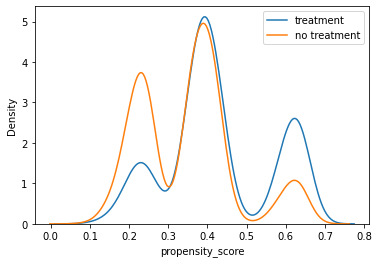

In [6]:
sns.kdeplot(df[df.treatment==1].propensity_score, label='treatment')
sns.kdeplot(df[df.treatment==0].propensity_score, label='no treatment')
plt.legend()

In [7]:
def apply_w(row):
    if row.treatment == 1:
        return 1/row.propensity_score
    elif row.treatment == 0:
        return 1/(1-row.propensity_score)
    else:
        raise Exception("WTF")

df['w'] = df.apply(lambda row: apply_w(row), axis=1)

Text(0.5, 1.0, 'Weights Histogram')

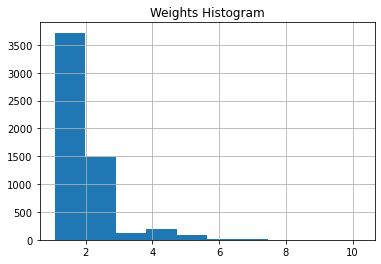

In [8]:
df['w'].hist(bins=10)
plt.title('Weights Histogram')

Weights look reasonable.

In [9]:
W = df['w']
A = df['treatment']
Y = df['death']
n = len(df)
ATE_ITPW = sum(W*A*Y)/n - sum(W*(1-A)*Y)/n
ATE_ITPW

0.03649582619905134

## <u> Model mu

### Find features for mu model:

In [10]:
df.corr()['death'].sort_values()  # correlation between death and the different columns

ARF                    -0.104839
meanbp1                -0.100588
CHF                    -0.028846
female                 -0.019384
wtf                    -0.017446
sepsis                 -0.006347
colcan                 -0.005622
w                       0.022048
Cirr                    0.023926
propensity_score_err    0.033071
lungcan                 0.047102
treatment               0.049868
propensity_score        0.065839
Coma                    0.083111
MOSF                    0.149264
age                     0.215895
death                   1.000000
Name: death, dtype: float64

In [11]:
df.corr()['age']['MOSF']  # correlation between age and MOSF 

-0.05623430840894392

## Fit models for mu0 & mu1

In [12]:
y_params = ['age', 'MOSF']  # using the same parameters for both models out of lazyness
treatment = df[df['treatment']==1].copy()
control = df[df['treatment']==0].copy()

y1_model = LogisticRegression(max_iter=500).fit(treatment[y_params], treatment['death'].values.ravel())
treatment['y_score'] = y1_model.predict_proba(treatment[y_params])[:,1]
treatment['y_score_err'] = treatment['death'] - treatment['y_score']
print('y1 model absolute error rate:', treatment['y_score_err'].abs().sum()/len(df))

y0_model = LogisticRegression(max_iter=500).fit(control[y_params], control['death'].values.ravel())
control['y_score'] = y0_model.predict_proba(control[y_params])[:,1]
control['y_score_err'] = control['death'] - control['y_score']
print('y0 model absolute error rate:', control['y_score_err'].abs().sum()/len(df))

df['mu_0'] = y0_model.predict_proba(df[y_params])[:,1]
df['mu_1'] = y1_model.predict_proba(df[y_params])[:,1]

y1 model absolute error rate: 0.1540349303932069
y0 model absolute error rate: 0.2672726735046269


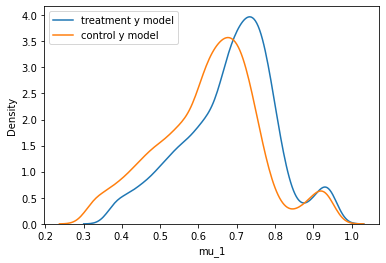

In [13]:
sns.kdeplot(df.mu_1, label='treatment y model')
sns.kdeplot(df.mu_0, label='control y model')
plt.legend()

In [14]:
U0 = df['mu_0']
U1 = df['mu_1']
P = df['propensity_score']
dr_correction = sum( (A-P) * ( (U1/P) - (U0/(1-P) ))) / n
dr_correction

0.0005985126610937297

In [15]:
ATE_DR = ATE_ITPW - dr_correction
print("The doubly-robust estimator for treatment effect in the RHC data calculated is:", ATE_DR)

The doubly-robust estimator for treatment effect in the RHC data calculated is: 0.03589731353795761


# <u>Q5 - C

# <u> Q6

# Q6 - A
E[Y1]-E[Y0] = b1 <br>
So.... yes!

# <U> Q6 - B - Simulate Data

In [16]:
def inverse_logit(x):
    return 1/(1+np.exp(-x))


def logit(x):
    return np.log(x/(1-x))


def plot_data(df):
    # plot IIDs
    sns.kdeplot(df['x'], label='X')
    sns.kdeplot(df['v'], label='V')
    plt.legend()
    plt.show()
    # plot Ys
    sns.kdeplot(df['y0'], label='y0')
    sns.kdeplot(df['y1'], label='y1')
    plt.legend()
    plt.xlabel('y')
    plt.show()
    # plot treatment
    sns.kdeplot(df['a_as_fraction'])
    plt.show()
    sns.scatterplot(data=df, x='x', y='a_as_fraction')
    plt.show()
    # plot observed
    sns.kdeplot(df[df['a']==1]['y'], label='A=1')
    sns.kdeplot(df[df['a']==0]['y'], label='A=0')
    plt.legend()
    plt.show()
    
    
def simulate_data(plot=False, sample_size=500, with_interaction=False):
    # define params
    b0 = 100
    b1 = 2
    b2 = 3.5
    b3 = 5
    epsilon_std = 3
    c0 = logit(0.2)
    c1 = np.log(2)
    b4 = 1
    df = pd.DataFrame()
    # create data
    df['x'] = np.random.normal(0, 1, size=sample_size)
    df['v'] = np.random.normal(0, 1, size=sample_size)
    df['e'] = np.random.normal(0, epsilon_std, size=sample_size)
    df['y0'] = b0 + b2*df['x'] + b3*df['v'] + df['e']
    df['y1'] = b0 + b1 + b2*df['x'] + b3*df['v'] + df['e']
    df['a_as_fraction'] = inverse_logit(c0 + c1*df['x'])
    df['a'] = round(df['a_as_fraction'])
    if with_interaction:
        df['av'] = df['a'] * df['v']
        df['y0'] += b4*df['av']
        df['y1'] += b4*df['av']
    df['y'] = df.apply(lambda row: row['y1'] if row['a']==1 else row['y0'], axis=1)
    if plot:
        plot_data(df)
    return df

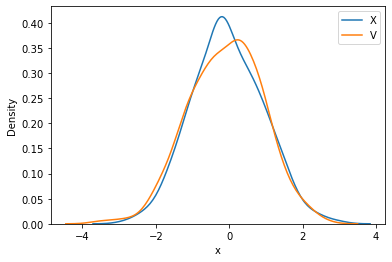

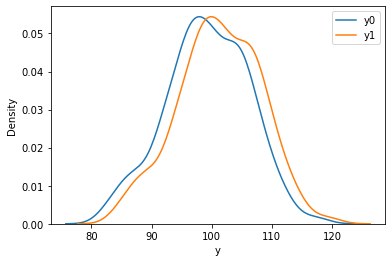

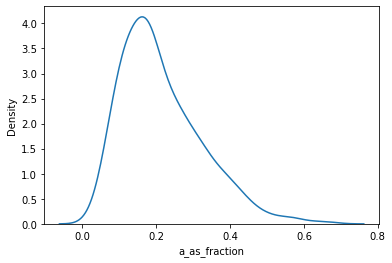

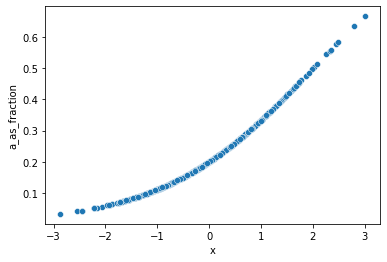

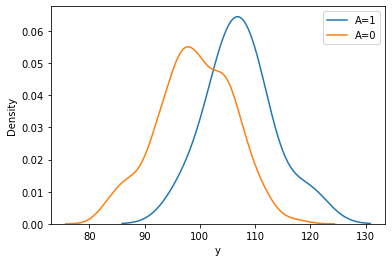

,x,v,e,y0,y1,a_as_fraction,a,y
0,0.729144,0.211036,3.047611,106.654794,108.654794,0.292993,0.0,106.654794
1,-1.087125,-0.250340,-3.044384,91.898975,93.898975,0.105285,0.0,91.898975
2,-0.163177,0.241492,3.062136,103.698477,105.698477,0.182515,0.0,103.698477
3,0.377752,0.775842,6.007550,111.208892,113.208892,0.245186,0.0,111.208892
4,0.921966,-0.505402,-0.409043,100.290826,102.290826,0.321424,0.0,100.290826
...,...,...,...,...,...,...,...,...
495,0.203276,0.939980,7.148783,112.560152,114.560152,0.223498,0.0,112.560152
496,-0.041977,0.628970,0.445395,103.443328,105.443328,0.195385,0.0,103.443328
497,0.429918,1.498102,2.562904,111.558128,113.558128,0.251939,0.0,111.558128
498,0.804501,2.069778,4.242515,117.407159,119.407159,0.303929,0.0,117.407159


In [17]:
df = simulate_data(plot=True)
df

# <u> Q6 - C

In [18]:
def calculate_naive_ATE(df):
    avg_y_grouped_by_a = df.groupby('a')['y'].mean()
    naive_ATE = avg_y_grouped_by_a[1] - avg_y_grouped_by_a[0]
    return naive_ATE

    
def calc_naive_ATT(matched):
    mean_y_grouped_by_a = matched.groupby('a')['y'].mean()
    return mean_y_grouped_by_a[1] - mean_y_grouped_by_a[0]


def calculate_pi(df):
    # simple logistic regression based on X
    df = df.copy()
    pi_model = LogisticRegression(max_iter=500).fit(df[['x']], df['a'].values.ravel())
    df['pi'] = pi_model.predict_proba(df[['x']])[:,1]
    return df


def calc_b1(data, confounders, outcome):
    # run linear regression on and return the coefficient we are interested in.
    model = LinearRegression()
    model.fit(data[confounders], data[outcome].values.ravel())
    b1 = model.coef_[1]
    return b1


def estimate_ATT_with_lr(matched, with_interaction):
    ATT_X = calc_b1(data=matched, confounders=['x','a'], outcome='y')
    ATT_XV = calc_b1(data=matched, confounders=['x','a','v'], outcome='y')
    ATT_XVAV = ATT_V_interaction = None
    if with_interaction:
        ATT_XVAV = calc_b1(data=matched, confounders=['x','a','v','av'], outcome='y')
    return ATT_X, ATT_XV, ATT_XVAV


def create_matched_dataset(df):
    treatment = df[df['a']==1]
    control = df[df['a']==0].copy()
    indices = []
    for treatment_index, treatment_row in treatment.iterrows():
        control_index = abs(treatment_row['pi']-control['pi']).idxmin()
        control.drop(control_index, inplace=True)
        indices.append(control_index)
        indices.append(treatment_index)
    matched = df.loc[indices,:].copy()
    return matched


def simulate_datasets(num_of_datasets, sample_size=500, with_interaction=False):
    results = []
    for i in range(num_of_datasets):
        df = simulate_data(sample_size=sample_size, with_interaction=with_interaction)
        naive_ATE = calculate_naive_ATE(df)
        df = calculate_pi(df)
        matched = create_matched_dataset(df)
        naive_ATT = calc_naive_ATT(matched)
        ATT_X, ATT_XV, XVA = estimate_ATT_with_lr(matched, with_interaction)
        results.append({'naive_ATE': naive_ATE, 'naive_ATT': naive_ATT, 'A+X_b1': ATT_X,
                        'A+X+V_b1': ATT_XV, 'A+X+V+AV_b1': XVA})
    results_df = pd.DataFrame.from_records(results)
    return results_df.describe().loc[['mean','std']]


# <u> Q6 - D

In [19]:
simulate_datasets(num_of_datasets=1000, sample_size=500)

,naive_ATE,naive_ATT,A+X_b1,A+X+V_b1
mean,10.411524,3.770663,1.842214,2.022568
std,1.957272,2.659155,4.205606,2.280927


- Looks like both naive methods have a low variance but are biased.
- Conversely, the ATT regression methods are not biased but suffer from high variance.
- Using both X & V in the regression reduced bias dramatically but it is still very high...
- That being said, it is not very surprising the variance is high as in the current setup the matched dataset is made of about 10 pairs...
- Despite the treated population being very small and biased towards high X values, the ATT seems to equal the ATE but with very high variance.

# <u> Q6 - E

In [20]:
simulate_datasets(num_of_datasets=1000, sample_size=2500)

,naive_ATE,naive_ATT,A+X_b1,A+X+V_b1
mean,10.483916,3.880815,2.010847,1.998840
std,0.798473,1.186876,1.687785,0.916185


- As expected, by using more data all the estimators got lower variance and no change in the bias.

# <U> Q6 - F

In [21]:
simulate_datasets(num_of_datasets=1000, sample_size=500, with_interaction=True)

,naive_ATE,naive_ATT,A+X_b1,A+X+V_b1,A+X+V+AV_b1
mean,10.498850,3.887350,1.945801,2.078444,2.009209
std,2.184543,2.864735,5.435156,2.811528,3.288562


In [22]:
simulate_datasets(num_of_datasets=1000, sample_size=2500, with_interaction=True)

,naive_ATE,naive_ATT,A+X_b1,A+X+V_b1,A+X+V+AV_b1
mean,10.527568,3.955428,2.049740,2.010568,2.016332
std,0.907428,1.186882,1.889238,0.884394,0.875825


# <U> Q6 - G
## What we have learned:
- Using matching to appproximate the ATT can be representitive of the ATE.
- Adding an interaction term may not reduce variance even if it is correctly specified. (wtf?)
- Greater sample size reduces variance (duh).
- The Naive ATE/ATT can be very biased.
- A correctly specified model reduces bias and does not necessarilly increase variance compared with the ATE.
- Matching is FUN!

# <U> Q7

## import R stuff as python doesn't really know how to do matching...

In [2]:
base = importr('base')
tidyverse = importr('tidyverse')
ggplot2 = importr('ggplot2')
MatchIt = importr('MatchIt')
optmatch = importr('optmatch')
r('''rm(list = ls())''')

<rpy2.rinterface.NULLType object at 0x7f2e7cb36aa0> [RTYPES.NILSXP]

In [3]:
r('''rhc.data <- read.csv2("../rhc_r.csv") %>% filter(meanbp1 > 0)    
    rhc.data<-na.omit(rhc.data)
    rhc.data$ID <- 1:nrow(rhc.data)
    rhc.data$Gender <- factor(rhc.data$female, levels =  c(0,1), labels = c("Male", "Female"))    
    rhc.data$Treatment <- factor(na.omit(rhc.data$treatment), levels =  c(0,1), labels = c("Untreated", "Treated"))
    set.seed(31415)
''')

<rpy2.rinterface.NULLType object at 0x7f2e7cb36aa0> [RTYPES.NILSXP]

In [4]:
rhc = r('rhc.data')
rhc.describe()

,X,ARF,CHF,Cirr,colcan,Coma,lungcan,MOSF,sepsis,age,female,meanbp1,treatment,death,ID
count,5655.000000,5655.000000,5655.000000,5655.000000,5655.000000,5655.00000,5655.000000,5655.000000,5655.000000,5655.000000,5655.000000,5655.000000,5655.000000,5655.000000,5655.000000
mean,2865.518833,0.435367,0.080106,0.039434,0.001238,0.07374,0.006720,0.069496,0.213970,61.379819,0.444562,79.630858,0.377896,0.647392,2828.000000
std,1656.066523,0.495849,0.271481,0.194643,0.035164,0.26137,0.081705,0.254318,0.410142,16.682113,0.496961,37.142349,0.484904,0.477824,1632.602217
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,18.041992,0.000000,10.000000,0.000000,0.000000,1.000000
25%,1431.500000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,50.138489,0.000000,50.000000,0.000000,0.000000,1414.500000
50%,2863.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,64.046997,0.000000,63.000000,0.000000,1.000000,2828.000000
75%,4298.500000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,73.988983,1.000000,115.000000,1.000000,1.000000,4241.500000
max,5735.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,101.847961,1.000000,259.000000,1.000000,1.000000,5655.000000


# <U> Q7 - A

In [6]:
matching = {}

In [7]:
def show_first_3_matches(key, data=matching):
    df = data[key]
    column = key+'_pair'
    matches = df.head(3)[column].values
    matches_df = df[df[column].isin(matches)]
    return matches_df.sort_values(by=column)

### (i) Exact Matching:


In [8]:
matching['exact'] = r('''m.exact <- matchit(formula = Treatment ~ age + meanbp1 + female, method = "exact", data = rhc.data)
                         rhc.data <- rhc.data %>% mutate(age.rnd = round(age,0)) # Add a rounded version of age
                         m.exact <- matchit(formula = treatment ~ age.rnd + meanbp1 + female, method = "exact", data = rhc.data)
                         match.data(m.exact, subclass='exact_pair')''')

In [9]:
show_first_3_matches('exact')

,X,ARF,CHF,Cirr,colcan,Coma,lungcan,MOSF,sepsis,age,female,meanbp1,treatment,death,ID,Gender,Treatment,age.rnd,weights,exact_pair
5,5,0,0,0,0,0,0,0,1,67.909973,0,65.0,1,1,5,Male,Treated,68.0,1.000000,1
2041,2065,1,0,0,0,0,0,0,0,68.391968,0,65.0,1,0,2041,Male,Treated,68.0,1.000000,1
2270,2298,0,0,0,0,0,0,0,1,68.070984,0,65.0,1,0,2270,Male,Treated,68.0,1.000000,1
3772,3822,1,0,0,0,0,0,0,0,67.895996,0,65.0,0,1,3772,Male,Untreated,68.0,2.030471,1
5221,5295,0,0,0,0,0,0,1,0,67.796997,0,65.0,0,1,5221,Male,Untreated,68.0,2.030471,1
5398,5474,0,0,0,0,0,0,0,0,68.481995,0,65.0,1,1,5398,Male,Treated,68.0,1.000000,1
13,13,0,0,0,0,0,0,0,1,74.709961,0,53.0,1,1,13,Male,Treated,75.0,1.000000,2
602,610,0,0,0,0,0,0,0,1,75.243957,0,53.0,1,1,602,Male,Treated,75.0,1.000000,2
3326,3370,0,1,0,0,0,0,0,0,75.060974,0,53.0,1,1,3326,Male,Treated,75.0,1.000000,2
4221,4277,0,0,0,0,0,0,0,1,74.567993,0,53.0,1,1,4221,Male,Treated,75.0,1.000000,2


#### Looks like we are getting many-to-many matches here... so it's not really matching is it.. so, not good.

### (ii) NN Mahalanobis: 


In [11]:
# TODO: set and report seed?

matching['nn_maha'] = r('''m.nn <- matchit(formula = Treatment ~ age + meanbp1 + female, method = "nearest", 
                      distance = "mahalanobis", data = rhc.data)
                      # Trick to get the matched sets variable, which match.data() does not report for nn
                      temp.df <- as.data.frame(m.nn$match.matrix)
                      colnames(temp.df) <- c("matched.unit")
                      temp.df$untrt.unit <- as.numeric(as.character(temp.df$matched.unit))
                      temp.df$trt.unit <- as.numeric(rownames(temp.df))
                      #now delete matches=na
                      temp.mathces.only <- temp.df %>% filter(!is.na(matched.unit))
                      temp.mathces.only$nn_maha_pair <- 1:nrow(temp.mathces.only)
                      rhc.data$nn_maha_pair <- 0
                      rhc.data$nn_maha_pair[temp.df$trt.unit]<- temp.mathces.only$nn_maha_pair
                      rhc.data$nn_maha_pair[temp.df$untrt.unit]<- temp.mathces.only$nn_maha_pair
                      # Keep matched data only
                      rhc.data %>% filter(nn_maha_pair>0)''')

In [13]:
show_first_3_matches('nn_maha')

,X,ARF,CHF,Cirr,colcan,Coma,lungcan,MOSF,sepsis,age,female,meanbp1,treatment,death,ID,Gender,Treatment,age.rnd,nn_maha_pair
2,2,0,0,0,0,0,0,0,1,78.178955,1,63.0,1,1,2,Female,Treated,78.0,1.0
2781,3765,0,0,0,0,1,0,0,0,77.554993,1,62.0,0,1,3717,Female,Untreated,78.0,1.0
3,3,0,0,0,0,0,0,1,0,46.091980,1,57.0,1,0,3,Female,Treated,46.0,2.0
2246,3043,0,0,0,0,0,0,0,1,45.026978,1,57.0,0,0,3005,Female,Untreated,45.0,2.0
1,1,0,0,0,0,0,0,0,0,70.250977,0,41.0,0,0,1,Male,Untreated,70.0,1691.0
3394,4592,0,0,0,0,0,0,0,1,69.007996,0,38.0,1,1,4528,Male,Treated,69.0,1691.0


#### Walla looks pretty good!

### (iii) Optimal Mahalanobis: 

In [24]:
matching['opt_maha'] = r('''m.opt <- matchit(formula = treatment ~ age + meanbp1 + female, method = "optimal", 
                            distance = "mahalanobis", data = rhc.data)
                            match.data(m.opt, subclass='opt_maha_pair') ''')

In [25]:
show_first_3_matches('opt_maha')

,X,ARF,CHF,Cirr,colcan,Coma,lungcan,MOSF,sepsis,age,...,death,ID,Gender,Treatment,age.rnd,nn_maha_pair,nn_pi,nn_pi_pair,weights,opt_maha_pair
1,1,0,0,0,0,0,0,0,0,70.250977,...,0,1,Male,Untreated,70.0,1691.0,1819.0,1819.0,1.0,690
4908,4976,0,0,0,0,0,0,0,1,68.273987,...,0,4908,Male,Treated,68.0,1832.0,1832.0,1832.0,1.0,690
2,2,0,0,0,0,0,0,0,1,78.178955,...,1,2,Female,Treated,78.0,1.0,1.0,1.0,1.0,1486
1851,1871,0,0,0,0,1,0,0,0,77.324951,...,0,1851,Female,Untreated,77.0,1493.0,563.0,563.0,1.0,1486
3,3,0,0,0,0,0,0,1,0,46.091980,...,0,3,Female,Treated,46.0,2.0,2.0,2.0,1.0,1935
3956,4010,0,0,0,0,0,0,0,1,44.259979,...,1,3956,Female,Untreated,44.0,1979.0,1858.0,1858.0,1.0,1935


#### Took longer to run but also looks pretty good!

### (iv) NN Propensity:

In [15]:
# TODO: set and report seed?
matching['nn_pi'] = r('''m.nn <- matchit(formula = Treatment ~ age + meanbp1 + female, method = "nearest", 
                         distance = "logit", data = rhc.data)
                         # Trick to get the matched sets variable, which match.data() does not report for nn
                         temp.df <- as.data.frame(m.nn$match.matrix)
                         colnames(temp.df) <- c("matched.unit")
                         temp.df$untrt.unit <- as.numeric(as.character(temp.df$matched.unit))
                         temp.df$trt.unit <- as.numeric(rownames(temp.df))
                         #now delete matches=na
                         temp.mathces.only <- temp.df %>% filter(!is.na(matched.unit))
                         temp.mathces.only$nn_pi_pair <- 1:nrow(temp.mathces.only)
                         rhc.data$nn_pi_pair <- 0
                         rhc.data$nn_pi_pair[temp.df$trt.unit]<- temp.mathces.only$nn_pi_pair
                         rhc.data$nn_pi_pair[temp.df$untrt.unit]<- temp.mathces.only$nn_pi_pair
                         # Keep matched data only
                         rhc.data %>% filter(nn_pi_pair>0)''')

In [16]:
show_first_3_matches('nn_pi')

,X,ARF,CHF,Cirr,colcan,Coma,lungcan,MOSF,sepsis,age,...,meanbp1,treatment,death,ID,Gender,Treatment,age.rnd,nn_maha_pair,nn_pi,nn_pi_pair
2,2,0,0,0,0,0,0,0,1,78.178955,...,63.0,1,1,2,Female,Treated,78.0,1.0,1.0,1.0
891,1204,0,0,0,0,0,0,0,0,80.738953,...,62.0,0,0,1188,Female,Untreated,81.0,1687.0,1.0,1.0
3,3,0,0,0,0,0,0,1,0,46.091980,...,57.0,1,0,3,Female,Treated,46.0,2.0,2.0,2.0
145,200,0,1,0,0,0,0,0,0,51.709992,...,67.0,0,0,197,Male,Untreated,52.0,1274.0,2.0,2.0
1,1,0,0,0,0,0,0,0,0,70.250977,...,41.0,0,0,1,Male,Untreated,70.0,1691.0,1819.0,1819.0
3680,4931,0,0,0,0,0,0,0,1,58.564972,...,45.0,1,1,4863,Male,Treated,59.0,1819.0,1819.0,1819.0


#### Matching male to female is not something we saw earlier and could be an issue. Also, there is a pretty big age gap that we didn't see before.. so based on this super shallow analysis it's really not as good.

### (v) Optimal propensity:

In [28]:
matching['opt_pi'] = r('''m.opt.logit <- matchit(formula = treatment ~ age + meanbp1 + female, method = "optimal", 
                         distance = "logit", data = rhc.data)
                         match.data(m.opt.logit, subclass='opt_pi_pair')''')

In [29]:
show_first_3_matches('opt_pi')

,X,ARF,CHF,Cirr,colcan,Coma,lungcan,MOSF,sepsis,age,...,ID,Gender,Treatment,age.rnd,nn_maha_pair,nn_pi,nn_pi_pair,distance,weights,opt_pi_pair
1,1,0,0,0,0,0,0,0,0,70.250977,...,1,Male,Untreated,70.0,1691.0,1819.0,1819.0,0.495301,1.0,143
3722,3770,0,0,0,0,0,0,0,1,68.996948,...,3722,Male,Treated,69.0,1385.0,1385.0,1385.0,0.516101,1.0,143
2,2,0,0,0,0,0,0,0,1,78.178955,...,2,Female,Treated,78.0,1.0,1.0,1.0,0.377522,1.0,1486
4332,4390,1,0,0,0,0,0,0,0,86.419983,...,4332,Male,Untreated,86.0,0.0,0.0,0.0,0.377053,1.0,1486
3,3,0,0,0,0,0,0,1,0,46.091980,...,3,Female,Treated,46.0,2.0,2.0,2.0,0.438481,1.0,1935
3920,3971,0,0,1,0,0,0,0,0,46.742981,...,3920,Male,Untreated,47.0,719.0,23.0,23.0,0.438867,1.0,1935


### As far as I can tell looks similar to the NN propensity matching.

# <U> Q7 -B

In [42]:
covars = ['age', 'female', 'meanbp1']

def calc_SMD(covar):
    return (treatment[covar].mean() - control[covar].mean()) / treatment[covar].std()

rows = []
for key, df in matching.items():
    treatment = df[df['Treatment']=='Treated']
    control = df[df['Treatment']=='Untreated']
    row = {'matching': key}
    for covar in covars:
        row[covar+'_SMD'] = calc_SMD(covar)
    rows.append(row)
SMD = pd.DataFrame.from_records(rows)

In [43]:
SMD

,matching,age_SMD,female_SMD,meanbp1_SMD
0,exact,-0.044987,-0.038119,-0.033795
1,nn_maha,-0.002047,0.000000,-0.027443
2,nn_pi,-0.024698,-0.002847,-0.004691
3,opt_maha,-0.004847,0.000000,-0.024627
4,opt_pi,-0.024011,-0.012335,-0.002766


## so........